In [4]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import sklearn.model_selection

c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, 
                cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, 
               s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, 
               alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, 
                     cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, 
                           colorscale=colorscale, cdiscrete=cdiscrete, 
                           psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

In [5]:
dflog = pd.read_csv("01_heights_weights_genders.csv.zip")
dflog.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


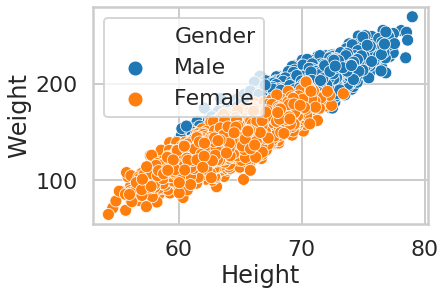

In [6]:
sns.scatterplot(data=dflog, x='Height', y='Weight', hue='Gender')

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(dflog[['Height','Weight']].values, 
                                              (dflog.Gender == "Male").values,random_state=5)

clf = LogisticRegression()
# Fit the model on the trainng data.
clf.fit(Xlr, ylr)
# Print the accuracy from the testing data.
print(accuracy_score(clf.predict(Xtestlr), ytestlr))

0.9252


In [8]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [9]:
clf = LogisticRegression()
score = cv_score(clf, Xlr, ylr)
print(score)

0.9172


In [10]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = sklearn.model_selection.GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

In [11]:
from sklearn.model_selection import train_test_split

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("Accuracy on training data: {:0.2f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.2f}".format(test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest

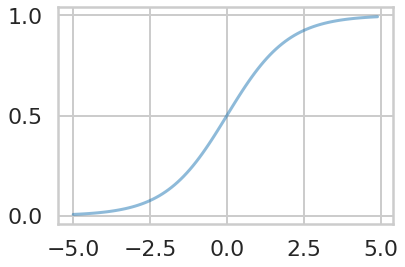

In [12]:
h = lambda z: 1. / (1 + np.exp(-z))
zs=np.arange(-5, 5, 0.1)
plt.plot(zs, h(zs), alpha=0.5);

In [13]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           dflog, ['Weight', 'Height'], 'Gender','Male')

BEST PARAMS {'C': 0.01}
Accuracy on training data: 0.92
Accuracy on test data:     0.92


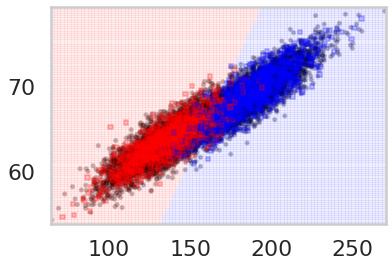

In [16]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, clf_l, alpha=0.2);

In [17]:
clf_l.predict_proba(Xtest_l)

array([[0.68762541, 0.31237459],
       [0.20614507, 0.79385493],
       [0.96776128, 0.03223872],
       ...,
       [0.01231479, 0.98768521],
       [0.99552388, 0.00447612],
       [0.00875479, 0.99124521]])

/opt/conda/envs/springboard/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: The following kwargs were not used by contour: 'axes'
/opt/conda/envs/springboard/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: The following kwargs were not used by contour: 'axes'


TypeError: clabel() got an unexpected keyword argument 'axes'

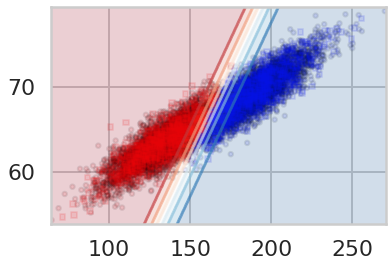

In [18]:
plt.figure()
ax = plt.gca()
points_plot_prob(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, clf_l, psize=20, alpha=0.1);